Below is a **sample Jupyter Notebook** illustrating how you might:

1. **Load** your `runs.jsonl` data into a Pandas DataFrame,
2. **Compute** basic metrics (exact matches, major matches, etc.),
3. **Visualize** results with a few different plots (table, bar charts, scatter, etc.).

This notebook is intentionally self-contained, so you can copy/paste it into a file like `analysis.ipynb`. Adjust and extend as needed.

---

In [19]:
!uv pip install -q pandas matplotlib seaborn

In [20]:
# analysis.ipynb

# --- 
# # LLM Evaluation Analysis

# This notebook demonstrates how to:
# 1. Load the runs from runs.jsonl
# 2. Create a DataFrame for analysis
# 3. Compute match statistics (exact, major, minor)
# 4. Visualize results using various charts
# ---

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from packaging.version import parse

# --------------- 
# 1. Load the data
# --------------- 
runs_file = "runs.jsonl"

records = []
with open(runs_file, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            rec = json.loads(line)
            records.append(rec)
        except Exception as e:
            print(f"Error parsing line: {line[:80]}... \n{e}")

df = pd.json_normalize(records, max_level=None)

# Let's confirm we have data
print(f"Loaded {len(df)} runs from {runs_file}")
df.head()

Error parsing line: {"ground_truth":{"tech":{"package_manager":"npm","name":"@angular/core"},"versio... 
Extra data: line 1 column 432 (char 431)
Loaded 155 runs from runs.jsonl


,timestamp,execution_time_seconds,output,parsed_version,lag_days,ground_truth.tech,ground_truth.version,ground_truth.release_date,llm_config.provider,llm_config.model,ground_truth.tech.package_manager,ground_truth.tech.name,parsed_version_exists
0,2025-02-06T15:31:48.602454Z,1.757877,The latest stable version of Python is 3.12.0.,3.12.0,NaN,python,3.13.1,2024-12-03,openai,gpt-4o-mini,NaN,NaN,NaN
1,2025-02-06T15:31:50.012597Z,1.124163,The latest stable version of FastAPI is 0.103.0.,0.103.0,523.0,NaN,0.115.8,2025-01-30,openai,gpt-4o-mini,pypi,fastapi,NaN
2,2025-02-06T15:31:51.252740Z,1.038345,The latest stable version of Django is 4.2.3.,4.2.3,583.0,NaN,5.1.6,2025-02-05,openai,gpt-4o-mini,pypi,django,NaN
3,2025-02-06T15:31:52.817530Z,1.443719,The latest stable version of SQLAlchemy is 2.0...,2.0.12,621.0,NaN,2.0.37,2025-01-10,openai,gpt-4o-mini,pypi,sqlalchemy,NaN
4,2025-02-06T15:31:54.075265Z,1.009112,The latest stable version of Pydantic is 1.10.7.,1.10.7,674.0,NaN,2.10.6,2025-01-24,openai,gpt-4o-mini,pypi,pydantic,NaN


### 2. Basic Data Inspection


In [21]:
# Let's see what columns we have
df.columns

Index(['timestamp', 'execution_time_seconds', 'output', 'parsed_version',
       'lag_days', 'ground_truth.tech', 'ground_truth.version',
       'ground_truth.release_date', 'llm_config.provider', 'llm_config.model',
       'ground_truth.tech.package_manager', 'ground_truth.tech.name',
       'parsed_version_exists'],
      dtype='object')


The columns will likely include things like:
- `ground_truth.tech` (which can be a string like `"python"` or a dict for library identifiers),
- `ground_truth.version`,
- `ground_truth.release_date`,
- `llm_config.provider`,
- `llm_config.model`,
- `timestamp`,
- `execution_time_seconds`,
- `output`,
- `parsed_version`,
- `parsed_version_exists`,
- `lag_days`.


In [22]:
def get_tech_name(row):
    """
    Takes either ground_truth.tech or ground_truth.name
    """
    # if ground_truth.tech.name is Nan, return ground_truth.tech
    if pd.isna(row['ground_truth.tech.name']):
        return row['ground_truth.tech']
    else:
        return row['ground_truth.tech.name']

df['tech_name'] = df.apply(get_tech_name, axis=1)
df['tech_version'] = df['ground_truth.version']
df['tech_release_date'] = pd.to_datetime(df['ground_truth.release_date'])

df['provider'] = df['llm_config.provider']
df['model'] = df['llm_config.model']

# Convert the timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Convert lag_days if it exists
if 'lag_days' in df.columns:
    # Some might be None
    df['lag_days'] = pd.to_numeric(df['lag_days'], errors='coerce')

df.head()

,timestamp,execution_time_seconds,output,parsed_version,lag_days,ground_truth.tech,ground_truth.version,ground_truth.release_date,llm_config.provider,llm_config.model,ground_truth.tech.package_manager,ground_truth.tech.name,parsed_version_exists,tech_name,tech_version,tech_release_date,provider,model
0,2025-02-06 15:31:48.602454+00:00,1.757877,The latest stable version of Python is 3.12.0.,3.12.0,NaN,python,3.13.1,2024-12-03,openai,gpt-4o-mini,NaN,NaN,NaN,python,3.13.1,2024-12-03,openai,gpt-4o-mini
1,2025-02-06 15:31:50.012597+00:00,1.124163,The latest stable version of FastAPI is 0.103.0.,0.103.0,523.0,NaN,0.115.8,2025-01-30,openai,gpt-4o-mini,pypi,fastapi,NaN,fastapi,0.115.8,2025-01-30,openai,gpt-4o-mini
2,2025-02-06 15:31:51.252740+00:00,1.038345,The latest stable version of Django is 4.2.3.,4.2.3,583.0,NaN,5.1.6,2025-02-05,openai,gpt-4o-mini,pypi,django,NaN,django,5.1.6,2025-02-05,openai,gpt-4o-mini
3,2025-02-06 15:31:52.817530+00:00,1.443719,The latest stable version of SQLAlchemy is 2.0...,2.0.12,621.0,NaN,2.0.37,2025-01-10,openai,gpt-4o-mini,pypi,sqlalchemy,NaN,sqlalchemy,2.0.37,2025-01-10,openai,gpt-4o-mini
4,2025-02-06 15:31:54.075265+00:00,1.009112,The latest stable version of Pydantic is 1.10.7.,1.10.7,674.0,NaN,2.10.6,2025-01-24,openai,gpt-4o-mini,pypi,pydantic,NaN,pydantic,2.10.6,2025-01-24,openai,gpt-4o-mini


In [23]:
# show all tech_name
df['tech_name'].unique()

array(['python', 'fastapi', 'django', 'sqlalchemy', 'pydantic', 'axios',
       'react', 'typescript',
       'org.springframework.boot:spring-boot-starter-parent', 'vue',
       '@angular/core', 'rust', 'langchain', 'ruby'], dtype=object)

In [24]:
## Deduplicate runs by (tech, llm)

df.drop_duplicates(subset=['tech_name', 'llm_config.model'], inplace=True)

df.head()


,timestamp,execution_time_seconds,output,parsed_version,lag_days,ground_truth.tech,ground_truth.version,ground_truth.release_date,llm_config.provider,llm_config.model,ground_truth.tech.package_manager,ground_truth.tech.name,parsed_version_exists,tech_name,tech_version,tech_release_date,provider,model
0,2025-02-06 15:31:48.602454+00:00,1.757877,The latest stable version of Python is 3.12.0.,3.12.0,NaN,python,3.13.1,2024-12-03,openai,gpt-4o-mini,NaN,NaN,NaN,python,3.13.1,2024-12-03,openai,gpt-4o-mini
1,2025-02-06 15:31:50.012597+00:00,1.124163,The latest stable version of FastAPI is 0.103.0.,0.103.0,523.0,NaN,0.115.8,2025-01-30,openai,gpt-4o-mini,pypi,fastapi,NaN,fastapi,0.115.8,2025-01-30,openai,gpt-4o-mini
2,2025-02-06 15:31:51.252740+00:00,1.038345,The latest stable version of Django is 4.2.3.,4.2.3,583.0,NaN,5.1.6,2025-02-05,openai,gpt-4o-mini,pypi,django,NaN,django,5.1.6,2025-02-05,openai,gpt-4o-mini
3,2025-02-06 15:31:52.817530+00:00,1.443719,The latest stable version of SQLAlchemy is 2.0...,2.0.12,621.0,NaN,2.0.37,2025-01-10,openai,gpt-4o-mini,pypi,sqlalchemy,NaN,sqlalchemy,2.0.37,2025-01-10,openai,gpt-4o-mini
4,2025-02-06 15:31:54.075265+00:00,1.009112,The latest stable version of Pydantic is 1.10.7.,1.10.7,674.0,NaN,2.10.6,2025-01-24,openai,gpt-4o-mini,pypi,pydantic,NaN,pydantic,2.10.6,2025-01-24,openai,gpt-4o-mini


### 4. Define Functions for Exact / Major / Minor Match

We can define a helper to compare versions, using `packaging.version.parse`:


In [25]:
def compare_versions(gt_version_str, llm_version_str):
    """
    Returns a tuple of booleans:
      (exact_match, major_match, minor_match)
    """
    if not gt_version_str or not llm_version_str:
        return (False, False, False)
    try:
        gt_v = parse(gt_version_str)
        llm_v = parse(llm_version_str)
    except Exception:
        return (False, False, False)

    exact = (gt_v == llm_v)
    major = (gt_v.major == llm_v.major)
    minor = major and (gt_v.minor == llm_v.minor)
    return (exact, major, minor)

exact_list = []
major_list = []
minor_list = []

for idx, row in df.iterrows():
    gt_version = row['tech_version']
    llm_version = row['parsed_version']
    exact, major, minor = compare_versions(gt_version, llm_version)
    exact_list.append(exact)
    major_list.append(major)
    minor_list.append(minor)

df['exact_match'] = exact_list
df['major_match'] = major_list
df['minor_match'] = minor_list

df.head(10)

,timestamp,execution_time_seconds,output,parsed_version,lag_days,ground_truth.tech,ground_truth.version,ground_truth.release_date,llm_config.provider,llm_config.model,...,ground_truth.tech.name,parsed_version_exists,tech_name,tech_version,tech_release_date,provider,model,exact_match,major_match,minor_match
0,2025-02-06 15:31:48.602454+00:00,1.757877,The latest stable version of Python is 3.12.0.,3.12.0,NaN,python,3.13.1,2024-12-03,openai,gpt-4o-mini,...,NaN,NaN,python,3.13.1,2024-12-03,openai,gpt-4o-mini,False,True,False
1,2025-02-06 15:31:50.012597+00:00,1.124163,The latest stable version of FastAPI is 0.103.0.,0.103.0,523.0,NaN,0.115.8,2025-01-30,openai,gpt-4o-mini,...,fastapi,NaN,fastapi,0.115.8,2025-01-30,openai,gpt-4o-mini,False,True,False
2,2025-02-06 15:31:51.252740+00:00,1.038345,The latest stable version of Django is 4.2.3.,4.2.3,583.0,NaN,5.1.6,2025-02-05,openai,gpt-4o-mini,...,django,NaN,django,5.1.6,2025-02-05,openai,gpt-4o-mini,False,False,False
3,2025-02-06 15:31:52.817530+00:00,1.443719,The latest stable version of SQLAlchemy is 2.0...,2.0.12,621.0,NaN,2.0.37,2025-01-10,openai,gpt-4o-mini,...,sqlalchemy,NaN,sqlalchemy,2.0.37,2025-01-10,openai,gpt-4o-mini,False,True,True
4,2025-02-06 15:31:54.075265+00:00,1.009112,The latest stable version of Pydantic is 1.10.7.,1.10.7,674.0,NaN,2.10.6,2025-01-24,openai,gpt-4o-mini,...,pydantic,NaN,pydantic,2.10.6,2025-01-24,openai,gpt-4o-mini,False,False,False
5,2025-02-06 15:31:55.348625+00:00,1.053145,The latest stable version of axios is 1.3.4.,1.3.4,651.0,NaN,1.7.9,2024-12-04,openai,gpt-4o-mini,...,axios,NaN,axios,1.7.9,2024-12-04,openai,gpt-4o-mini,False,True,False
6,2025-02-06 15:31:56.628771+00:00,1.022998,The latest stable version of React is 18.2.0.,18.2.0,905.0,NaN,19.0.0,2024-12-05,openai,gpt-4o-mini,...,react,NaN,react,19.0.0,2024-12-05,openai,gpt-4o-mini,False,False,False
7,2025-02-06 15:31:58.687462+00:00,1.272297,The latest stable version of TypeScript is 5.2.2.,5.2.2,503.0,NaN,5.7.3,2025-01-08,openai,gpt-4o-mini,...,typescript,NaN,typescript,5.7.3,2025-01-08,openai,gpt-4o-mini,False,True,False
8,2025-02-06 15:31:59.328330+00:00,0.620565,3.11.5,3.11.5,NaN,python,3.13.1,2024-12-03,google_genai,gemini-1.5-flash,...,NaN,NaN,python,3.13.1,2024-12-03,google_genai,gemini-1.5-flash,False,True,False
9,2025-02-06 15:32:00.032905+00:00,0.560900,0.90.1,0.90.1,721.0,NaN,0.115.8,2025-01-30,google_genai,gemini-1.5-flash,...,fastapi,NaN,fastapi,0.115.8,2025-01-30,google_genai,gemini-1.5-flash,False,True,False


### 5. Basic Summary Table


In [26]:
# How many total runs?
total_runs = len(df)
num_exact = df['exact_match'].sum()
num_major = df['major_match'].sum()
num_minor = df['minor_match'].sum()

print("Total Runs:", total_runs)
print(f"Exact Matches: {num_exact} ({num_exact/total_runs:.1%})")
print(f"Major Matches: {num_major} ({num_major/total_runs:.1%})")
print(f"Minor Matches: {num_minor} ({num_minor/total_runs:.1%})")

# Also let's check average/median lag days (where not NaN)
valid_lag = df['lag_days'].dropna()
if len(valid_lag) > 0:
    print(f"Average lag (days): {valid_lag.mean():.1f}")
    print(f"Median lag (days): {valid_lag.median():.1f}")

Total Runs: 112
Exact Matches: 0 (0.0%)
Major Matches: 87 (77.7%)
Minor Matches: 7 (6.2%)
Average lag (days): 504.9
Median lag (days): 490.0


## Visualizations

### A. Heatmap (Matrix) of LLM vs. Tech (Exact Match)

We’ll pivot the data so rows are `tech_name`, columns are LLM “provider/model”, and values are e.g. `exact_match` rate:


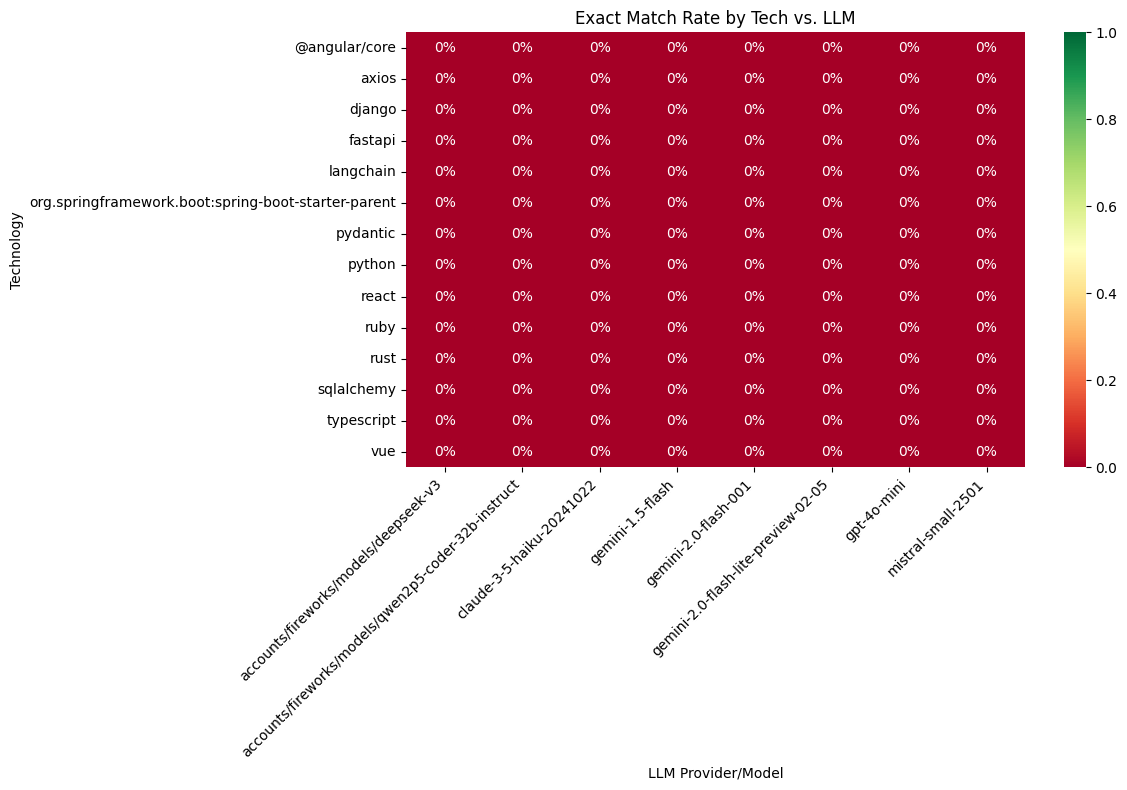

In [27]:
# Create shorter LLM identifiers for better readability
df['llm_id'] = df.apply(lambda x: f"{x['provider']}/{x['model'].split('-')[0]}", axis=1)

# Create the grouped data
grouped = df.groupby(['tech_name', 'llm_config.model'])['exact_match'].mean().reset_index()
pivot_data = grouped.pivot(index='tech_name', columns='llm_config.model', values='exact_match').fillna(0)

# Create the plot with improved formatting
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_data, 
    annot=True,
    cmap='RdYlGn',
    fmt=".0%",
    vmin=0,
    vmax=1,
    center=0.5
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.title("Exact Match Rate by Tech vs. LLM")
plt.xlabel("LLM Provider/Model")
plt.ylabel("Technology")
plt.tight_layout()
plt.show()

- Cells close to 1.0 (100%) show perfect exact-match for that (Tech, LLM).
- Cells near 0.0 mean the LLM never matched exactly for that tech.


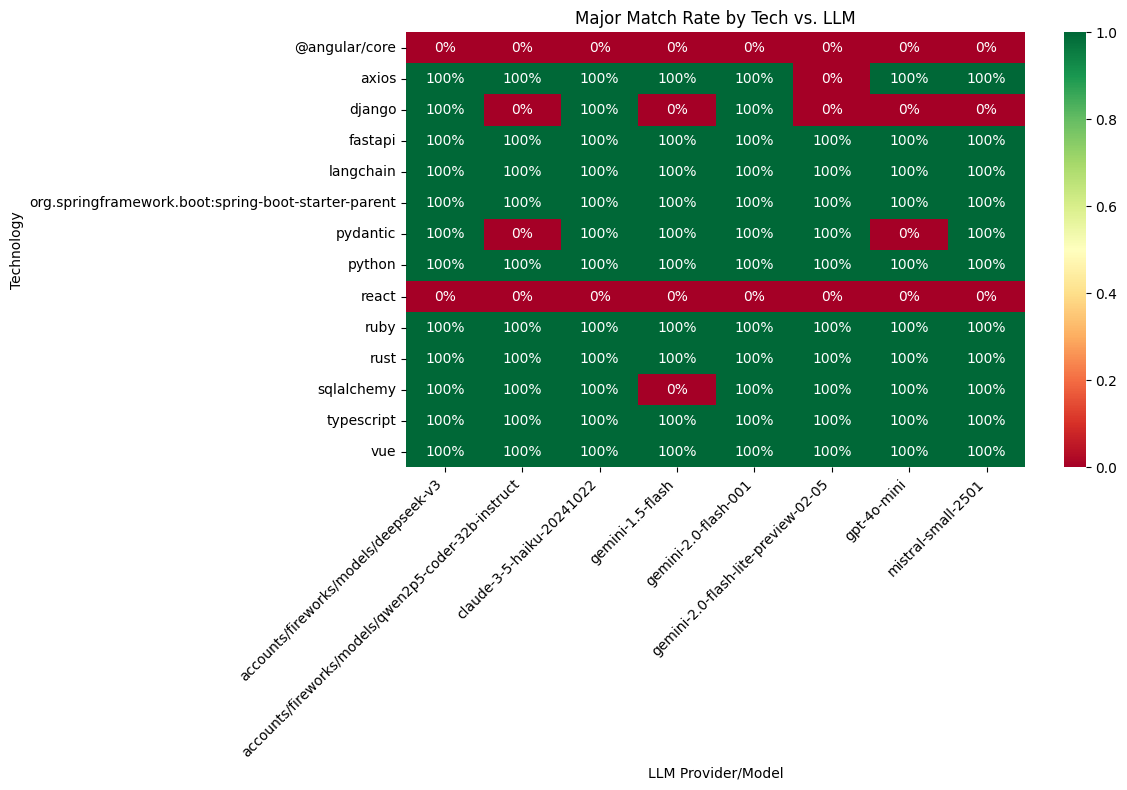

In [28]:
# Create the grouped data
grouped = df.groupby(['tech_name', 'llm_config.model'])['major_match'].mean().reset_index()
pivot_data = grouped.pivot(index='tech_name', columns='llm_config.model', values='major_match').fillna(0)

# Create the plot with improved formatting
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_data, 
    annot=True,
    cmap='RdYlGn',
    fmt=".0%",
    vmin=0,
    vmax=1,
    center=0.5
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.title("Major Match Rate by Tech vs. LLM")
plt.xlabel("LLM Provider/Model")
plt.ylabel("Technology")
plt.tight_layout()
plt.show()

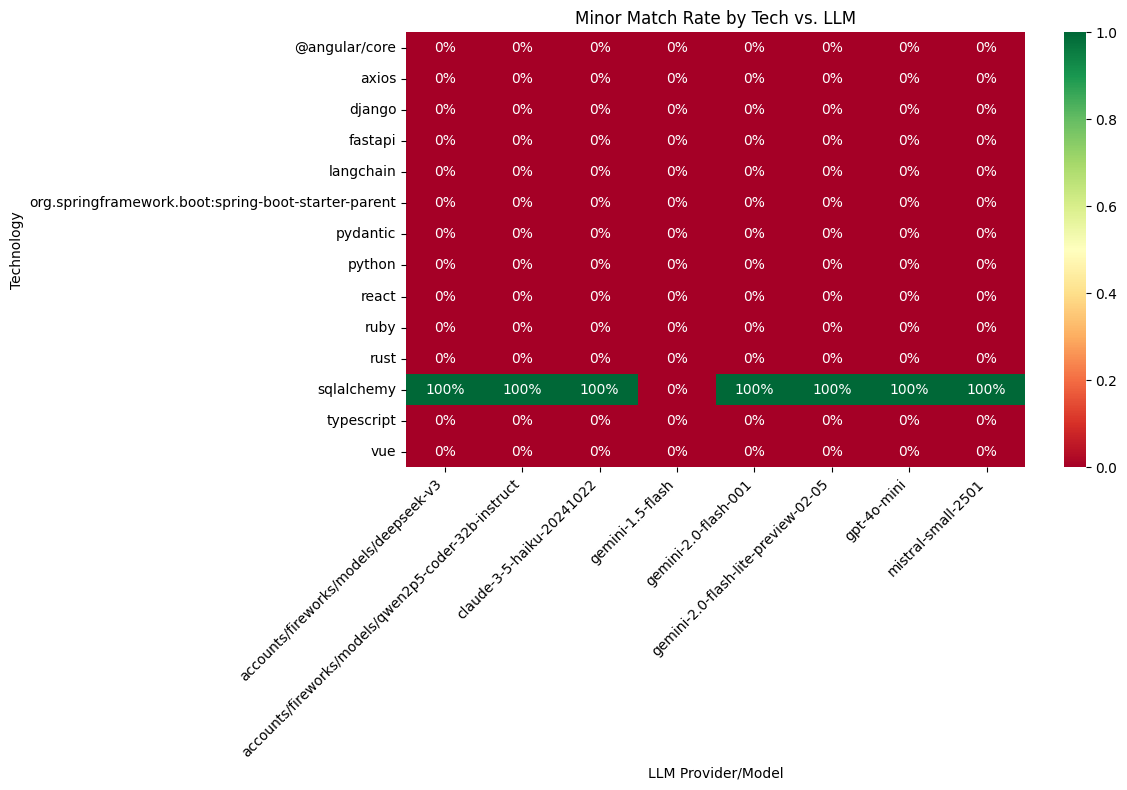

In [29]:
# Create the grouped data
grouped = df.groupby(['tech_name', 'llm_config.model'])['minor_match'].mean().reset_index()
pivot_data = grouped.pivot(index='tech_name', columns='llm_config.model', values='minor_match').fillna(0)

# Create the plot with improved formatting
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_data, 
    annot=True,
    cmap='RdYlGn',
    fmt=".0%",
    vmin=0,
    vmax=1,
    center=0.5
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.title("Minor Match Rate by Tech vs. LLM")
plt.xlabel("LLM Provider/Model")
plt.ylabel("Technology")
plt.tight_layout()
plt.show()

### B. Bar Chart: Average Lag by LLM

We can look at average `lag_days` per LLM across all technologies:


/var/folders/6h/vqhsr5bd6jj2kcxm44lj76zw0000gp/T/ipykernel_69665/3886123792.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lag_grouped.values, y=lag_grouped.index, palette='viridis')


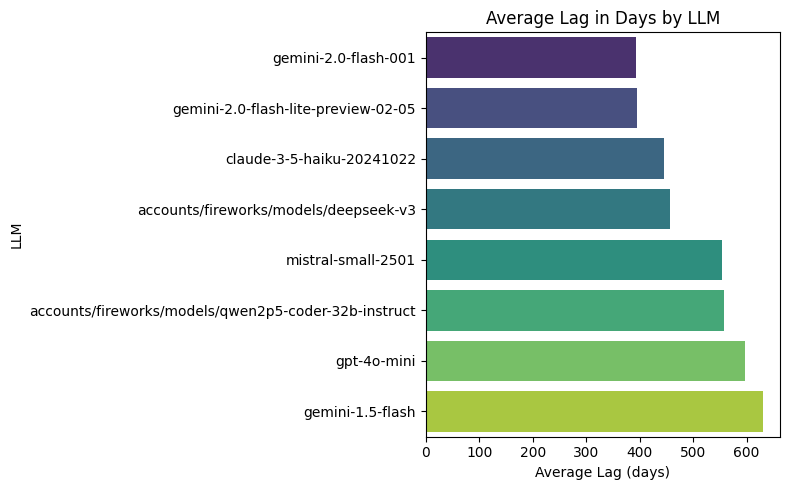

In [30]:
lag_df = df.dropna(subset=['lag_days'])  # only rows where lag_days is not NaN
lag_grouped = lag_df.groupby('llm_config.model')['lag_days'].mean().sort_values()

plt.figure(figsize=(8, 5))
sns.barplot(x=lag_grouped.values, y=lag_grouped.index, palette='viridis')
plt.xlabel("Average Lag (days)")
plt.ylabel("LLM")
plt.title("Average Lag in Days by LLM")
plt.tight_layout()
plt.show()

### C. Bar Chart: Exact Match Rate by LLM


/var/folders/6h/vqhsr5bd6jj2kcxm44lj76zw0000gp/T/ipykernel_69665/2670303317.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=llm_exact.values, y=llm_exact.index, palette='Blues')


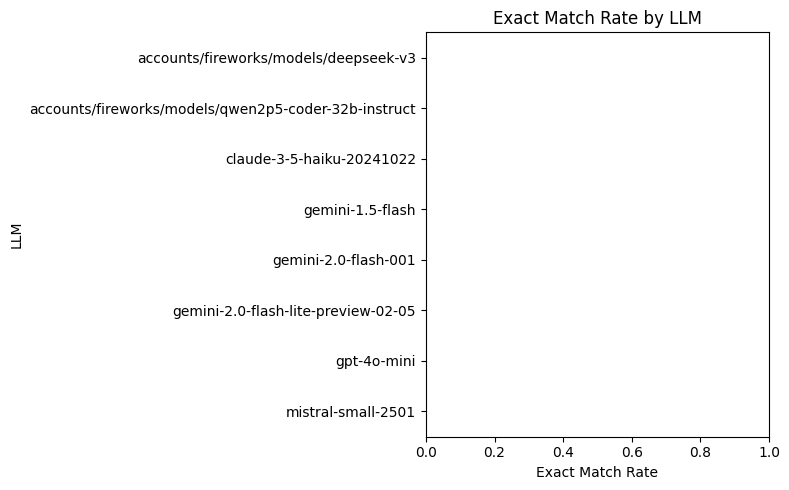

In [31]:
llm_exact = df.groupby('llm_config.model')['exact_match'].mean().sort_values()

plt.figure(figsize=(8, 5))
sns.barplot(x=llm_exact.values, y=llm_exact.index, palette='Blues')
plt.xlabel("Exact Match Rate")
plt.ylabel("LLM")
plt.title("Exact Match Rate by LLM")
plt.xlim(0,1)
plt.tight_layout()
plt.show()

/var/folders/6h/vqhsr5bd6jj2kcxm44lj76zw0000gp/T/ipykernel_69665/2839638945.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=llm_major.values, y=llm_major.index, palette='Blues')


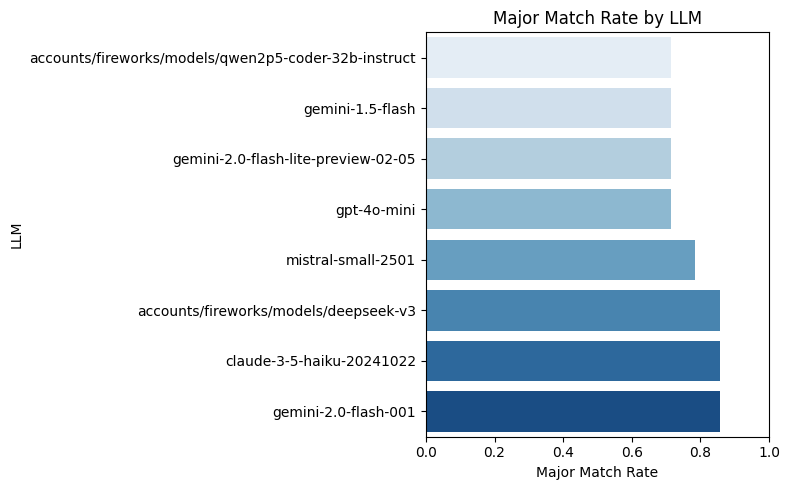

In [32]:
llm_major = df.groupby('llm_config.model')['major_match'].mean().sort_values()

plt.figure(figsize=(8, 5))
sns.barplot(x=llm_major.values, y=llm_major.index, palette='Blues')
plt.xlabel("Major Match Rate")
plt.ylabel("LLM")
plt.title("Major Match Rate by LLM")
plt.xlim(0,1)
plt.tight_layout()
plt.show()

/var/folders/6h/vqhsr5bd6jj2kcxm44lj76zw0000gp/T/ipykernel_69665/3360244986.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=llm_minor.values, y=llm_minor.index, palette='Blues')


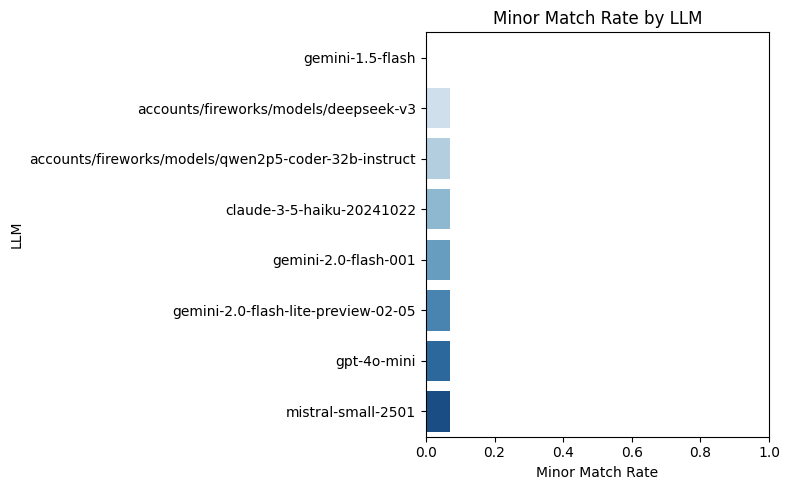

In [33]:
llm_minor = df.groupby('llm_config.model')['minor_match'].mean().sort_values()

plt.figure(figsize=(8, 5))
sns.barplot(x=llm_minor.values, y=llm_minor.index, palette='Blues')
plt.xlabel("Minor Match Rate")
plt.ylabel("LLM")
plt.title("Minor Match Rate by LLM")
plt.xlim(0,1)
plt.tight_layout()
plt.show()

### E. (Optional) Radar / Spider Chart

A spider chart can be used to compare multiple metrics per LLM (exact match rate, average lag, major match rate, etc.). However, implementing that in pure Matplotlib is a bit more involved. You might try a specialized library or do a custom implementation. Below is just a skeleton to show the idea—**not** a fully polished spider chart:


A real spider chart in Python typically involves custom polar coordinates code. If you want that, see an official tutorial like [Matplotlib’s Radar Chart example](https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html) or use a library like [plotly.express.line_polar](https://plotly.com/python/polar-chart/) for a more straightforward approach.


---